# Семинар 12

- Матрица $A$ - Тёплицева
- Получим выражение для предобуславливателя Чена

$$ \min_C \| A - C \|^2_F $$

- Ответ
 
$$ c_j = \frac{j t_{j-n} + (n-j)t_j}{n}, \quad j = 1, \ldots (n-1) $$

## Сравним эффективность для GMRES

In [23]:
import numpy as np
import scipy.linalg as splin

n = 50
col = np.random.rand(n)
row = np.random.rand(n)
T = splin.toeplitz(col, row)
print(T)
c_col = np.hstack((col, row[1:][::-1]))
# print(col, c_col)

def toeplitz_matvec(x):
    n = x.shape[0]
    y = np.zeros(2*n - 1)
    y[:n] = x.copy()
    z = np.fft.ifft(np.fft.fft(c_col) * np.fft.fft(y))
    return z[:n].real

[[0.39568413 0.96278595 0.72963643 ... 0.1769474  0.21194478 0.49858633]
 [0.09538572 0.39568413 0.96278595 ... 0.61093272 0.1769474  0.21194478]
 [0.96021773 0.09538572 0.39568413 ... 0.55166262 0.61093272 0.1769474 ]
 ...
 [0.79067021 0.25473918 0.46181897 ... 0.39568413 0.96278595 0.72963643]
 [0.61149316 0.79067021 0.25473918 ... 0.09538572 0.39568413 0.96278595]
 [0.47430987 0.61149316 0.79067021 ... 0.96021773 0.09538572 0.39568413]]


In [24]:
x = np.random.randn(n)
print(np.linalg.norm(T @ x - toeplitz_matvec(x)))
print(np.linalg.eigvals(T))
print(np.linalg.cond(T))

6.489835850066627e-15
[ 2.53983889e+01+0.j         -2.55370087e+00+2.67502518j
 -2.55370087e+00-2.67502518j  3.19072318e+00+0.66659689j
  3.19072318e+00-0.66659689j -2.79187162e+00+0.67890586j
 -2.79187162e+00-0.67890586j  1.11785701e+00+2.63281617j
  1.11785701e+00-2.63281617j  7.67757558e-01+2.37963729j
  7.67757558e-01-2.37963729j  1.75858623e+00+0.65644043j
  1.75858623e+00-0.65644043j  4.49279999e-01+2.26964058j
  4.49279999e-01-2.26964058j  5.22879621e-01+1.97861517j
  5.22879621e-01-1.97861517j -1.57651655e+00+1.30292578j
 -1.57651655e+00-1.30292578j -6.36759301e-02+2.05645749j
 -6.36759301e-02-2.05645749j  1.40502499e+00+0.j
  6.02645321e-02+1.87194698j  6.02645321e-02-1.87194698j
  5.62271253e-01+1.28759999j  5.62271253e-01-1.28759999j
  8.80550083e-01+0.j         -1.27742051e+00+0.36793471j
 -1.27742051e+00-0.36793471j -6.44845207e-01+1.30464924j
 -6.44845207e-01-1.30464924j -5.33032778e-01+1.29199104j
 -5.33032778e-01-1.29199104j -5.96099137e-01+1.20444269j
 -5.96099137e-01-

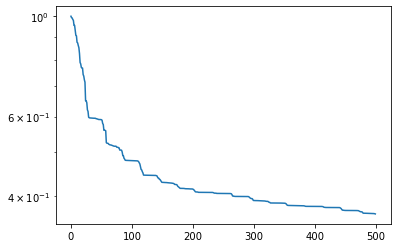

In [25]:
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt
%matplotlib inline
gmres_conv = []
def callback_gm(r):
    gmres_conv.append(r.copy())
    
A = spsplin.LinearOperator((n, n), matvec=lambda x: toeplitz_matvec(x))
b = np.random.randn(n)
x, _ = spsplin.gmres(A, b, callback=callback_gm, restart=30)
# print(x)
plt.semilogy(gmres_conv)

In [26]:
print(np.linalg.norm(A @ x - b))

2.8443103827005505


[-1.04820677 -0.63560087 -3.70541897 -3.41325696  2.00989082  2.05944334
  4.91980524 -0.33212047 -0.99295238 -1.84938117 -2.50972264  1.40534706
 -0.24779846 -0.92746156  1.16660594 -0.39192077  3.22338252  1.51545902
  0.21553717  2.82722777 -2.23599699 -2.87414429  1.52805474 -0.72683542
 -1.82629288 -1.97517266 -1.65934741 -0.18457326 -2.68128855 -0.0221937
 -1.48376547 -1.15797607  1.41494364  1.98673782  2.77582165  4.50706086
  2.58367291 -0.14610836  2.38655038  2.79422102  0.74415127  0.71737322
 -0.98971612 -2.65335633  1.10459286  1.90433671  0.78117711 -0.57174778
 -1.65662681 -6.98955142]


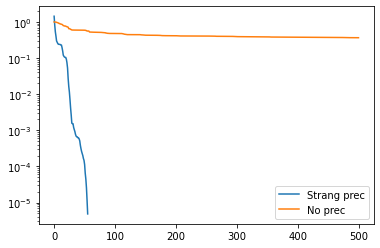

In [27]:
# Introduce preconditioner

M = spsplin.LinearOperator((n, n), matvec=lambda x: \
                   (np.fft.ifft(np.fft.fft(x) / np.fft.fft(col))).real)

gmres_prec_conv = []
def callback_gm(r):
    gmres_prec_conv.append(r.copy())
    
A = spsplin.LinearOperator((n, n), matvec=lambda x: toeplitz_matvec(x))
x, _ = spsplin.gmres(A, b, callback=callback_gm, M=M, restart=30)
print(x)
plt.semilogy(gmres_prec_conv, label="Strang prec")
plt.semilogy(gmres_conv, label="No prec")
plt.legend()

[0.39568413 0.09538572 0.96021773 0.12144614 0.99556753 0.04903704
 0.59691247 0.41886276 0.77575986 0.09217605 0.72868197 0.22596515
 0.28957289 0.44890673 0.60297301 0.1095856  0.05760411 0.23002542
 0.30994299 0.71703703 0.15230727 0.26533724 0.54538471 0.08766452
 0.2561729  0.65795208 0.9398771  0.66983834 0.66412431 0.23306838
 0.57042876 0.82247733 0.19608556 0.89202483 0.68862678 0.51829186
 0.10229695 0.2689416  0.11242577 0.64163179 0.18306435 0.8260446
 0.7679874  0.56861158 0.44880472 0.46181897 0.25473918 0.79067021
 0.61149316 0.47430987]
[-1.15737622 -0.48729319 -3.72933869 -3.88834345  2.02966123  2.20819921
  5.32348825 -0.30724724 -1.23077363 -2.18529506 -3.04327114  1.64114506
  0.11350814 -1.05303622  1.45363247 -0.30614741  3.32158191  1.7280891
  0.23284261  2.97801372 -2.50552386 -3.18606162  1.54895551 -0.83853381
 -1.85429499 -1.97401083 -1.89635113 -0.02433454 -2.77944058 -0.12452935
 -1.41578649 -1.38566055  1.38907345  2.11829655  2.95420808  4.833359
  2.81

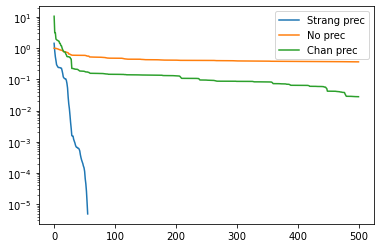

In [28]:
print(col)
chan_prec_col = (col * (n - np.arange(n)) + 
                 np.arange(n) * np.hstack((0, col[::-1][:-1]))) / n

M_chan = spsplin.LinearOperator((n, n), matvec=lambda x: \
        np.fft.ifft(np.fft.fft(x) / np.fft.fft(chan_prec_col)).real)

gmres_prec_chan_conv = []
def callback_gm(r):
    gmres_prec_chan_conv.append(r.copy())
    
A = spsplin.LinearOperator((n, n), matvec=lambda x: toeplitz_matvec(x))
x, _ = spsplin.gmres(A, b, callback=callback_gm, M=M_chan, restart=30)
print(x)
plt.semilogy(gmres_prec_conv, label="Strang prec")
plt.semilogy(gmres_conv, label="No prec")
plt.semilogy(gmres_prec_chan_conv, label="Chan prec")
plt.legend()